In [1]:
from emle.models import EMLE, ANI2xEMLE, MACEEMLE
from emle_bespoke.patching import EMLEPatched
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from math import sqrt
import time as time

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
# Load the reference data
mol = "water"
with open(
    "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/merged/merged_ref_data_iter_3.pkl",
    "rb",
) as f:
    data = pkl.load(f)

# Bespoke model
use_bespoke = True  
alpha_mode = "species"
bespoke_model = (
    f"/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke.mat"
    if use_bespoke
    else None
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
alpha_static = 1.0
beta_induced = 1.0

emle_model = EMLEPatched(
    device=device,
    dtype=dtype,
    model=bespoke_model,
    alpha_static=alpha_static,
    beta_induced=beta_induced,
    method="electrostatic",
    alpha_mode=alpha_mode
)

"""
emle_model = MACEEMLE(
    device=device,
    dtype=dtype,
    emle_model=bespoke_model,
    #alpha_static=alpha_static,
    #beta_induced=beta_induced,
    emle_method="electrostatic",
    alpha_mode="species"
)
"""


'\nemle_model = MACEEMLE(\n    device=device,\n    dtype=dtype,\n    emle_model=bespoke_model,\n    #alpha_static=alpha_static,\n    #beta_induced=beta_induced,\n    emle_method="electrostatic",\n    alpha_mode="species"\n)\n'

In [4]:
from emle.train._utils import pad_to_max
import torch

# Pad data to max length
z = pad_to_max(data["z"]).to(device=device, dtype=torch.int64)
charges_mm = pad_to_max(data["charges_mm"]).to(device=device, dtype=dtype)
xyz_qm = pad_to_max(data["xyz_qm"]).to(device=device, dtype=dtype)
xyz_mm = pad_to_max(data["xyz_mm"]).to(device=device, dtype=dtype)

# Constants
HARTREE_TO_KJ_MOL = 2625.5  # Example conversion factor

# Define batch parameters
n_batches = 32
n_samples = z.shape[0]
batch_size = n_samples // n_batches

# Initialize storage for results
e_static_all = []
e_ind_all = []

# Timer start
time0 = time.time()

# Batch processing
for i in range(n_batches):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size if i < n_batches - 1 else n_samples  # Handle last batch
    print(f"Processing batch {i+1}/{n_batches} with {batch_end - batch_start} samples")
    
    # Forward pass for current batch
    e_static_emle, e_ind_emle = emle_model.forward(
        #torch.where(z[batch_start:batch_end] == 0, -1, z[batch_start:batch_end]),
        z[batch_start:batch_end],
        charges_mm[batch_start:batch_end],
        xyz_qm[batch_start:batch_end],
        xyz_mm[batch_start:batch_end],
    )

    # Convert units
    e_static_emle = e_static_emle * HARTREE_TO_KJ_MOL
    e_ind_emle = e_ind_emle * HARTREE_TO_KJ_MOL

    # Collect results
    e_static_all.append(e_static_emle.detach().cpu())
    e_ind_all.append(e_ind_emle.detach().cpu())

# Concatenate results into single tensors
e_static_emle = torch.cat(e_static_all, dim=0)
e_ind_emle = torch.cat(e_ind_all, dim=0)

# Timer end
print("Time taken for batched forward pass: ", time.time() - time0)

Processing batch 1/32 with 62 samples
Processing batch 2/32 with 62 samples
Processing batch 3/32 with 62 samples
Processing batch 4/32 with 62 samples
Processing batch 5/32 with 62 samples
Processing batch 6/32 with 62 samples
Processing batch 7/32 with 62 samples
Processing batch 8/32 with 62 samples
Processing batch 9/32 with 62 samples
Processing batch 10/32 with 62 samples
Processing batch 11/32 with 62 samples
Processing batch 12/32 with 62 samples
Processing batch 13/32 with 62 samples
Processing batch 14/32 with 62 samples
Processing batch 15/32 with 62 samples
Processing batch 16/32 with 62 samples
Processing batch 17/32 with 62 samples
Processing batch 18/32 with 62 samples
Processing batch 19/32 with 62 samples
Processing batch 20/32 with 62 samples
Processing batch 21/32 with 62 samples
Processing batch 22/32 with 62 samples
Processing batch 23/32 with 62 samples
Processing batch 24/32 with 62 samples
Processing batch 25/32 with 62 samples
Processing batch 26/32 with 62 sam

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2639103/4027918116.py:36: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_2639103/4027918116.py:37: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_2639103/4027918116.py:56: SyntaxWarning: invalid escape sequence '\m'
  axes[1].se

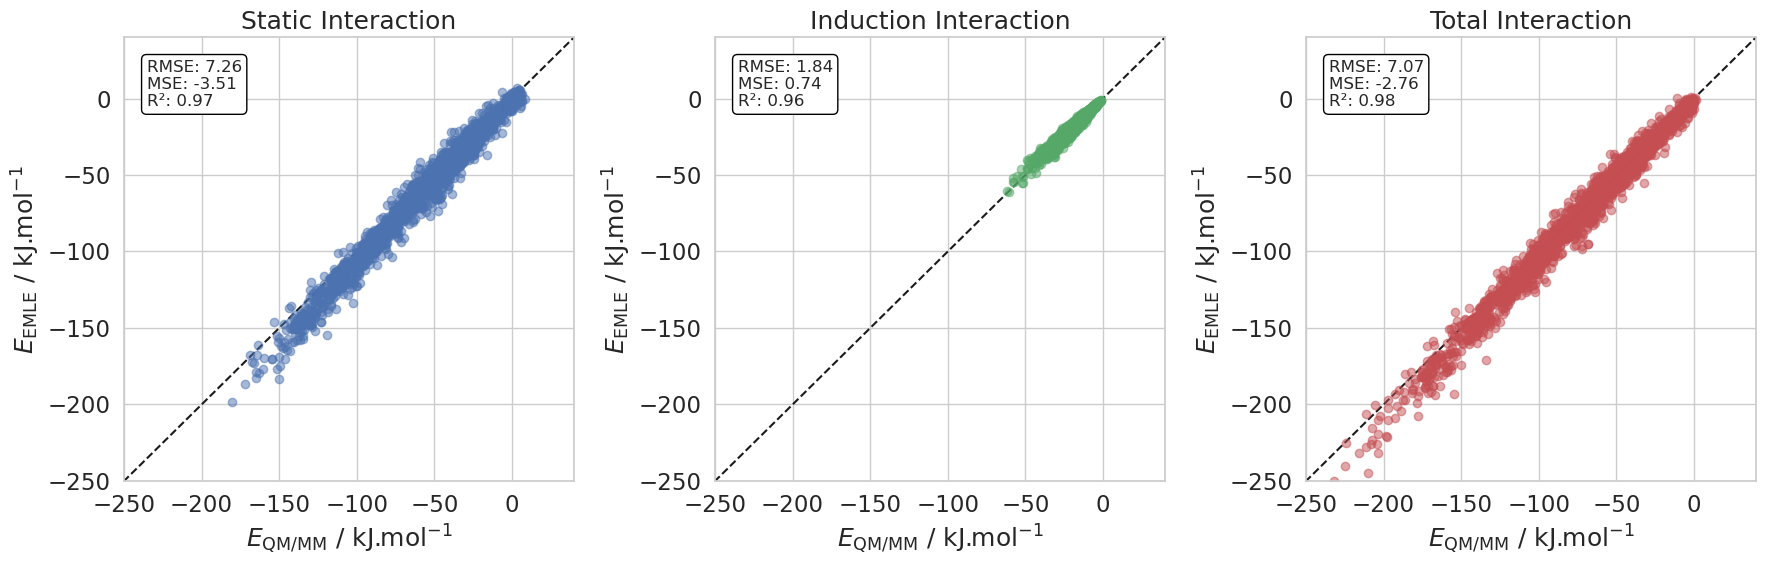

In [5]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", 
        font_scale=1.5)

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_ind = np.array([x.item() for x in data["e_ind"]])
e_static_emle = np.array([x.item() for x in e_static_emle])
e_ind_emle = np.array([x.item() for x in e_ind_emle])

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x

# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(predicted_values - true_values)
    rmse = sqrt(np.mean((predicted_values - true_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2

# Set limits for all subplots and plot reference line
xmin, xmax = -250, 40
ymin, ymax = -250, 40
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static, e_static_emle, "bo", label="Static", alpha=0.5)
axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_title("Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
axes[1].plot(e_ind, e_ind_emle, "go", label="Induction", alpha=0.5)
axes[1].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Induction Interaction")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
rmse_total, mse_total, r2_total = compute_metrics(
    e_static + e_ind, e_static_emle + e_ind_emle
)
axes[2].plot(e_static + e_ind, e_static_emle + e_ind_emle, "ro", label="Total", alpha=0.5)
axes[2].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Total Interaction")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
#  save this to np svetxt columns
# e_static + e_ind, e_static_emle + e_ind_emle
np.savetxt("emle_patched.txt", np.column_stack((e_static + e_ind, e_static_emle + e_ind_emle)), fmt='%.6f')